# Calculating Fluxes

In [279]:
import autoroot
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import finitediffx as fdx
from jaxtyping import Array, Float
# from jaxsw._src.domain.base import Domain
from jaxsw._src.domain.base_v2 import Domain, init_domain_1d
import math
import torch
import torch.nn.functional as F
import einops
import seaborn as sns

jax.config.update("jax_enable_x64", True)
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's look at the typical material derivative

$$
\frac{Dq}{Dt} := \partial_t q + \vec{u}\cdot\nabla q
$$



where the velocity vector is given by

$$
\vec{u} = 
\left[ u, v \right]^\top
$$

In particular, we are interested in the advection term which is defined as:

$$
\begin{aligned}
\text{Advection}: &= \vec{u} \cdot \nabla q = u\partial_x q + v\partial_y q \\
&= \nabla \cdot (\vec{u}q) = \partial_x (uq) + \partial_y (vq) 
\end{aligned}
$$

where the second equation is the conservative form.

The problem comes into play when we are on a staggered grid. The velocities are on one grid and the tracer is on a difference grid. The velocity

$$
\begin{aligned}
\text{Variable}: \psi &\in\Omega_\psi \\
\text{Zonal Velocity}: u &\in\Omega_u \\
\text{Meridional Velocity}: v &\in\Omega_v \\
\text{Tracer}: q &\in\Omega_q \\
\end{aligned}
$$



$$
\begin{aligned}
\Omega_\psi &\in[N_x,N_y] && && [x_0,y_0] && && [x_1,y_1] \\ 
\Omega_u &\in[N_x,N_y-1] && && [x_0,y_0+\frac{1}{2}dy] && && [x_1,y_1-\frac{1}{2}dy]  \\ 
\Omega_v &\in[N_x-1,N_y] && && [x_0+\frac{1}{2}dx,y_0] && && [x_1-\frac{1}{2}dx,y_1]  \\ 
\Omega_q &\in[N_x-1,N_y-1] && && [x_0+\frac{1}{2}dx,y_0+\frac{1}{2}dy] && && [x_1-\frac{1}{2}dx,y_1-\frac{1}{2}dy] 
\end{aligned}
$$







So if $q$ is on a staggered domain.

In [280]:
from loguru import logger


def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 2))

    for i in range(num_axis):
        pts = ax[i].imshow(field[i].T, origin="lower", cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = np.min(quantity)
    max_ = np.max(quantity)
    mean_ = np.mean(quantity)
    median_ = np.mean(quantity)
    jax.debug.print(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In [281]:
from jaxsw._src.models import qg as F_qg
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.domain.qg import create_qg_multilayer_mat, LayerDomain
from jaxsw._src.masks import Mask
from jaxsw._src.operators.functional.finitevol.geostrophic import gradient_perpendicular

In [282]:
# Low Resolution
# Nx, Ny = 128, 128
Nx, Ny = 256+1, 256+1
# High Resolution
# Nx, Ny = 769, 961

# Lx, Ly = 3840.0e3, 4800.0e3
Lx, Ly = 5_120.0e3, 5_120.0e3

dx, dy = Lx / Nx, Ly / Ny

xy_domain = Domain.Domain(
    xmin=(0.0,0.0), 
    xmax=(Lx,Ly),
    Lx=(Lx,Ly),
    Nx=(Nx, Ny), dx=(dx, dy)
)

params = F_qg.PDEParams(y0=0.5 * Ly)



# heights
# heights = [350.0, 750.0, 2900.0]
heights = [400.0, 1_100.0, 2_600.0]

# reduced gravities
reduced_gravities = [0.025, 0.0125]

# initialize layer domain
layer_domain = LayerDomain(heights, reduced_gravities, correction=False)

In [283]:
# octogonal domain
domain_type = "octogonal"
mask = np.ones((Nx-1,Ny-1))
for i in range(Nx//4):
    for j in range(Ny//4):
        if i+j < min(Nx//4, Ny//4):
            mask[i,j] = 0.
            mask[i,-1-j] = 0.
            mask[-1-i,j] = 0.
            mask[-1-i,-1-j] = 0.
            
masks = Mask.init_mask(mask, variable="q")

# domain_type = "rectangular"

# mask = jnp.ones((Nx,Ny))
# mask = mask.at[0].set(0.0)
# mask = mask.at[-1].set(0.0)
# mask = mask.at[:,0].set(0.0)
# mask = mask.at[:,-1].set(0.0)

# masks = Mask.init_mask(mask, variable="psi")

In [284]:
psi.shape

(3, 257, 257)

In [285]:
# open psi
psi = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_360d.npy")[0]
psi *= masks.psi.values
# calculate potential vorticity
q = F_qg.calculate_potential_vorticity(psi, domain=xy_domain, layer_domain=layer_domain, params=params, masks_psi=masks.psi, masks_q=masks.q)
# calculate velocities
u, v = gradient_perpendicular(u=psi, dx=xy_domain.dx[0], dy=xy_domain.dx[1])

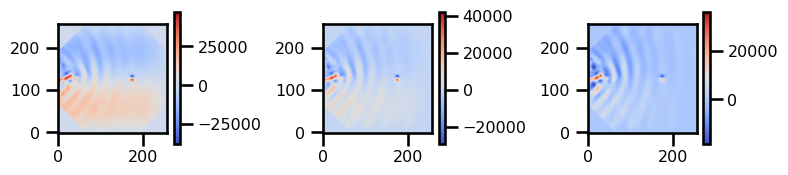

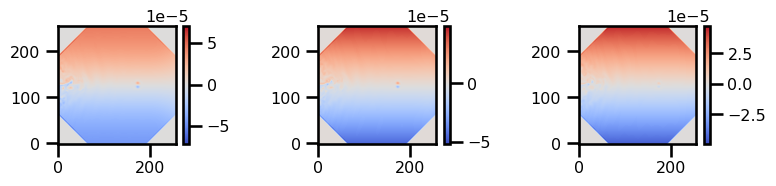

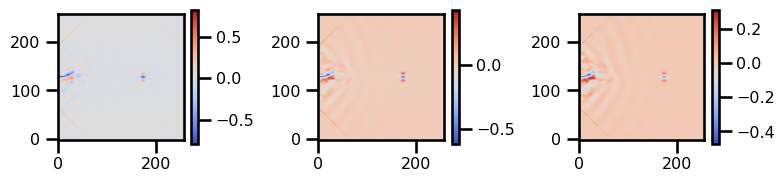

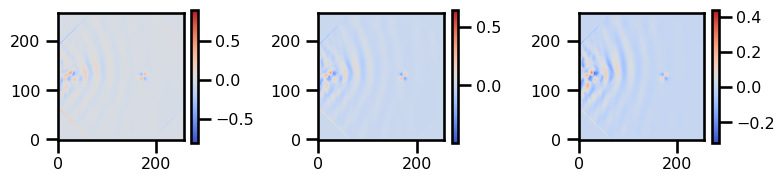

In [286]:
plot_field(psi)
plot_field(q)
plot_field(u)
plot_field(v)

In [287]:
def weno3z(qm, q0, qp):
    """
    3-points non-linear left-biased stencil reconstruction:

    qm-----q0--x--qp

    An improved weighted essentially non-oscillatory scheme for hyperbolic
    conservation laws, Borges et al, Journal of Computational Physics 227 (2008).
    """
    eps = 1e-14

    qi1 = -1./2.*qm + 3./2.*q0
    qi2 = 1./2.*(q0 + qp)

    beta1 = (q0-qm)**2
    beta2 = (qp-q0)**2
    tau = torch.abs(beta2-beta1)

    g1, g2 = 1./3., 2./3.
    w1 = g1 * (1. + tau / (beta1 + eps))
    w2 = g2 * (1. + tau / (beta2 + eps))

    qi_weno3 = (w1*qi1 + w2*qi2) / (w1 + w2)

    return qi_weno3

def flux_3pts_mask(q, u, dim, mask_u_d1, mask_u_d2plus):
    print_debug_quantity(q.numpy(), "Q")
    print_debug_quantity(u.numpy(), "U")
    print("----")
    n = q.shape[dim]
    pad1 = () if dim == -1 else (0,0)
    pad2 = (0,0) if dim == -1 else ()
    print(pad1, pad2)
    
    
    # 3 Point Flux
    qm, q0, qp = q.narrow(dim, 0, n-2), q.narrow(dim, 1, n-2), \
                 q.narrow(dim, 2, n-2)
    
#     print_debug_quantity(qm.numpy(), "QM")
#     print_debug_quantity(q0.numpy(), "Q0")
#     print_debug_quantity(qp.numpy(), "QP")
    
#     print("----")
    

    qi_left_i_3pt = weno3z(qm, q0, qp)
    qi_left_i_3pt = F.pad(qi_left_i_3pt, pad1+(1,0)+pad2)
    print_debug_quantity(qi_left_i_3pt.numpy(), "Q LEFT 3PT")
    
    qi_right_i_3pt = weno3z(qp, q0, qm)
    qi_right_i_3pt = F.pad(qi_right_i_3pt, pad1+(0,1)+pad2)
    print_debug_quantity(qi_right_i_3pt.numpy(), "Q RIGHT 3PT")
    
    print("----")

    # 1 Point Flux
    qi_left_i_1pt = q.narrow(dim, 0, n-1)
    qi_right_i_1pt = q.narrow(dim, 1, n-1)
    
    
    print_debug_quantity(qi_left_i_1pt.numpy(), "Q LEFT 1PT")
    print_debug_quantity(qi_right_i_1pt.numpy(), "Q RIGHT 1PT")
    
    
    print("----")
    
    # calculate plus minus
    u_pos = F.relu(u)
    u_neg = u - u_pos
    # NORMAL FLUX
    
    flux_1pt = u_pos * qi_left_i_1pt + u_neg * qi_right_i_1pt
    
    print_debug_quantity(flux_1pt.numpy(), "FLUX 1PT")
    
    
    flux_3pt = u_pos * qi_left_i_3pt + u_neg * qi_right_i_3pt
    print_debug_quantity(flux_3pt.numpy(), "FLUX 3PT")
    print("----")
    
    

    flux = mask_u_d1 * flux_1pt + mask_u_d2plus * flux_3pt
    
    print_debug_quantity(flux.numpy(), "TOTAL FLUX")

    return qi_left_i_3pt, qi_right_i_3pt, flux

In [288]:
# # qi_left_torch, qi_right_torch, flux = flux_3pts(x, u, 0)
# qi_left_torch, qi_right_torch, flux = flux_3pts_mask(
#     torch.Tensor(np.asarray(q[None, None, ...])), 
#     torch.Tensor(np.asarray(u[None, None, :, 1:-1, :])), -2, 
#     torch.Tensor(np.asarray(masks.u.distbound1[1:-1][None, None, ...])),
#     torch.Tensor(np.asarray(masks.u.distbound2plus[1:-1][None, None, ...]))
# )

In [289]:
# # qi_left_torch, qi_right_torch, flux = flux_3pts(x, u, 0)
# qi_left_torch, qi_right_torch, flux = flux_3pts_mask(
#     torch.Tensor(np.asarray(q[None, None, ...])), 
#     torch.Tensor(np.asarray(v[None, None, ..., 1:-1])), -1, 
#     torch.Tensor(np.asarray(masks.v.distbound1[:, 1:-1][None, None, ...])),
#     torch.Tensor(np.asarray(masks.v.distbound2plus[:, 1:-1][None, None, ...]))
# )

In [290]:

def linear2(qm, qp):
    """
    2-points linear reconstruction:

    qm--x--qp

    """
    return 0.5 * (qm + qp)
def linear3_left(qm, q0, qp):
    """
    3-points linear left-biased stencil reconstruction:

    qm-----q0--x--qp

    """
    return -1./6.*qm + 5./6.*q0 + 1./3.*qp

def linear5_left(qmm, qm, q0, qp, qpp):
    """
    5-points linear left-biased stencil reconstruction

    qmm----qm-----q0--x--qp----qpp

    """
    return 1./30.*qmm - 13./60.*qm + 47./60.*q0 + 9./20.*qp - 1/20 *qpp

def flux_5pts_mask(
        q, u, dim, mask_u_d1,
        mask_u_d2, mask_u_d3plus):
    
    print_debug_quantity(q.numpy(), "Q")
    print_debug_quantity(u.numpy(), "U")
    print("----")
    n = q.shape[dim]
    pad1 = () if dim == -1 else (0,0)
    pad2 = (0,0) if dim == -1 else ()
    
    # 5 PTS FLUX (LINEAR)
    qmm, qm, q0, qp, qpp = q.narrow(dim, 0, n-4), q.narrow(dim, 1, n-4), \
                           q.narrow(dim, 2, n-4), q.narrow(dim, 3, n-4), \
                           q.narrow(dim, 4, n-4)
    # qi5_left = F.pad(weno5z(qmm, qm, q0, qp, qpp), pad1+(2,1)+pad2)
    # qi5_right = F.pad(weno5z(qpp, qp, q0, qm, qmm), pad1+(1,2)+pad2)
    qi5_left = F.pad(linear5_left(qmm, qm, q0, qp, qpp), pad1+(2,1)+pad2)
    qi5_right = F.pad(linear5_left(qpp, qp, q0, qm, qmm), pad1+(1,2)+pad2)
    print_debug_quantity(qi5_left.numpy(), "Q LEFT 5PT")
    print_debug_quantity(qi5_right.numpy(), "Q RIGHT 5PT")
    print("PADDING")
    # print(qi5_right[0,0,0,-2])
    print("----")
    
    # 3 PTS FLUX (LINEAR)

    # qi4 = F.pad(
        # linear4(q.narrow(dim, 0, n-3), q.narrow(dim, 1, n-3),
                # q.narrow(dim, 2, n-3), q.narrow(dim, 3, n-3)),
        # pad1+(1,1)+pad2)

    qm, q0, qp = q.narrow(dim, 0, n-2), q.narrow(dim, 1, n-2), \
                 q.narrow(dim, 2, n-2)
    qi3_left = F.pad(linear3_left(qm, q0, qp), pad1+(1,0)+pad2)

    qi3_right = F.pad(linear3_left(qp, q0, qm), pad1+(0,1)+pad2)
    
    print_debug_quantity(qi3_left.numpy(), "Q LEFT 3PT")
    print_debug_quantity(qi3_right.numpy(), "Q RIGHT 3PT")
    print("----")
    
    
    # 1 PTS FLUX (LINEAR)

    qi2 = linear2(q.narrow(dim, 0, n-1), q.narrow(dim, 1, n-1))
    
    print_debug_quantity(qi2.numpy(), "Q 1PT")
    print("----")

    u_pos = F.relu(u)
    u_neg = u - u_pos
    print_debug_quantity(u_pos.numpy(), "U POST")
    print_debug_quantity(u_neg.numpy(), "U NEG")
    print("----")
    
    flux_1pt = u * qi2
    flux_3pt = u_pos*qi3_left + u_neg*qi3_right
    flux_5pt = u_pos*qi5_left + u_neg*qi5_right
    
    print_debug_quantity(flux_1pt.numpy(), "FLUX 1PT")
    print_debug_quantity(flux_3pt.numpy(), "FLUX 3PT")
    print_debug_quantity(flux_5pt.numpy(), "FLUX 5PT")
    print("----")
    
    flux = mask_u_d1 * flux_1pt + mask_u_d2 * flux_3pt + mask_u_d3plus * flux_5pt
    print_debug_quantity(flux.numpy(), "TOTAL FLUX")

    return flux

In [291]:
# qi_left_torch, qi_right_torch, flux = flux_3pts(x, u, 0)
flux = flux_5pts_mask(
    torch.Tensor(np.asarray(q[None, None, ...])), 
    torch.Tensor(np.asarray(u[None, None, :, 1:-1, :])), -2, 
    torch.Tensor(np.asarray(masks.u.distbound1[1:-1][None, None, ...])),
    torch.Tensor(np.asarray(masks.u.distbound2[1:-1][None, None, ...])),
    torch.Tensor(np.asarray(masks.u.distbound3plus[1:-1][None, None, ...]))
)

Q: (1, 1, 3, 256, 256) | -7.109572e-05 | -7.978994e-09 | -7.978994e-09 | 7.058449e-05
U: (1, 1, 3, 255, 256) | -7.937311e-01 | -4.743639e-13 | -4.743639e-13 | 8.212052e-01
----
Q LEFT 5PT: (1, 1, 3, 255, 256) | -6.866989e-05 | -5.783516e-09 | -5.783516e-09 | 6.684787e-05
Q RIGHT 5PT: (1, 1, 3, 255, 256) | -6.721713e-05 | -6.300173e-09 | -6.300173e-09 | 6.615402e-05
PADDING
----
Q LEFT 3PT: (1, 1, 3, 255, 256) | -6.898878e-05 | -7.137487e-09 | -7.137487e-09 | 6.824612e-05
Q RIGHT 3PT: (1, 1, 3, 255, 256) | -6.624290e-05 | -7.151980e-09 | -7.151980e-09 | 6.577937e-05
----
Q 1PT: (1, 1, 3, 255, 256) | -6.243898e-05 | -7.590101e-09 | -7.590101e-09 | 6.121465e-05
----
U POST: (1, 1, 3, 255, 256) | 0.000000e+00 | 5.506792e-03 | 5.506792e-03 | 8.212052e-01
U NEG: (1, 1, 3, 255, 256) | -7.937311e-01 | -5.506792e-03 | -5.506792e-03 | 0.000000e+00
----
FLUX 1PT: (1, 1, 3, 255, 256) | -4.778925e-05 | -1.071482e-09 | -1.071482e-09 | 4.815209e-05
FLUX 3PT: (1, 1, 3, 255, 256) | -5.110379e-05 | -1.2

In [292]:
# qi_left_torch, qi_right_torch, flux = flux_3pts(x, u, 0)
flux = flux_5pts_mask(
    torch.Tensor(np.asarray(q[None, ...])), 
    torch.Tensor(np.asarray(v[None, :, :, 1:-1])), -1 ,
    torch.Tensor(np.asarray(masks.v.distbound1[:, 1:-1][None, ...])),
    torch.Tensor(np.asarray(masks.v.distbound2[:, 1:-1][None, ...])),
    torch.Tensor(np.asarray(masks.v.distbound3plus[:, 1:-1][None, ...]))
)

Q: (1, 3, 256, 256) | -7.109572e-05 | -7.978994e-09 | -7.978994e-09 | 7.058449e-05
U: (1, 3, 256, 255) | -8.212052e-01 | 0.000000e+00 | 0.000000e+00 | 9.066958e-01
----
Q LEFT 5PT: (1, 3, 256, 255) | -6.870866e-05 | 8.267326e-08 | 8.267326e-08 | 6.614746e-05
Q RIGHT 5PT: (1, 3, 256, 255) | -6.728567e-05 | -9.520487e-08 | -9.520487e-08 | 6.693673e-05
PADDING
----
Q LEFT 3PT: (1, 3, 256, 255) | -6.876664e-05 | 8.105346e-08 | 8.105346e-08 | 6.577809e-05
Q RIGHT 3PT: (1, 3, 256, 255) | -6.641335e-05 | -9.524484e-08 | -9.524484e-08 | 6.830379e-05
----
Q 1PT: (1, 3, 256, 255) | -6.241132e-05 | -7.553300e-09 | -7.553300e-09 | 6.121669e-05
----
U POST: (1, 3, 256, 255) | 0.000000e+00 | 7.499299e-03 | 7.499299e-03 | 9.066958e-01
U NEG: (1, 3, 256, 255) | -8.212052e-01 | -7.499299e-03 | -7.499299e-03 | 0.000000e+00
----
FLUX 1PT: (1, 3, 256, 255) | -4.796279e-05 | -1.705010e-08 | -1.705010e-08 | 1.509687e-05
FLUX 3PT: (1, 3, 256, 255) | -5.119268e-05 | -1.982446e-08 | -1.982446e-08 | 1.598919e-0

In [293]:
import jax.numpy as jnp
import kernex as kex
import jax
import numpy as np

In [294]:
from jaxsw._src.operators.functional.interp.upwind import (
    upwind_1pt,
    upwind_1pt_bnds,
    upwind_2pt_bnds,
    upwind_3pt,
    upwind_3pt_bnds,
    upwind_5pt,
    plusminus,
)
from jaxsw._src.operators.functional.interp.linear import (
    linear_3pts_left,
    linear_3pts_right,
    linear_2pts,
)


* interp_3pt_weno
* interp_1pt
* u plusmins
* flux + interp_1pt + mask
* flux + interp3pt
* sum fluxes

---

**Methods**:

* `dim`: 0 (x-axis), 1 (y-axis)
* `num_pts`: 1, 3, 5
* `method`: linear, weno, wenoz
* `mask` (depends): `u_mask1`, `u_mask2`, `umask_2plus`, `umask_3plus`

In [295]:

def tracer_flux_3pt_mask(
    q: Array,
    u: Array,
    dim: int,
    u_mask1: Array,
    u_mask2plus: Array,
    method: str = "linear",
):
    
    print_debug_quantity(q, "Q")
    print_debug_quantity(u, "U")
    # get padding
    if dim == 0:
        pad_left = ((1, 0), (0, 0))
        pad_right = ((0, 1), (0, 0))
    elif dim == 1:
        pad_left = ((0, 0), (1, 0))
        pad_right = ((0, 0), (0, 1))
    else:
        msg = f"Dims should be between 0 and 1!"
        msg += f"\nDims: {dim}"
        raise ValueError(msg)
        
    print("----")
    
    # 3 point flux
    qi_left_i_3pt, qi_right_i_3pt = jax.vmap(upwind_3pt, in_axes=(0,None,None))(q, dim, method)


    # add padding
    qi_left_i_3pt = jnp.pad(qi_left_i_3pt, pad_width=((0,0),) + pad_left)
    qi_right_i_3pt = jnp.pad(qi_right_i_3pt, pad_width=((0,0),) + pad_right)
    
    print_debug_quantity(qi_left_i_3pt, "Q LEFT 3PT")
    print_debug_quantity(qi_right_i_3pt, "Q RIGHT 3PT")
    
    print("----")

    # 1 point flux
    qi_left_i_1pt, qi_right_i_1pt = jax.vmap(upwind_1pt, in_axes=(0,None))(q, dim)
    print_debug_quantity(qi_left_i_1pt, "Q LEFT 1PT")
    print_debug_quantity(qi_right_i_1pt, "Q RIGHT 1PT")
    
    print("----")


    

    # calculate +ve and -ve points
    u_pos, u_neg = plusminus(u)

    # calculate upwind flux
    flux_1pt = u_pos * qi_left_i_1pt + u_neg * qi_right_i_1pt
    flux_3pt = u_pos * qi_left_i_3pt + u_neg * qi_right_i_3pt
    
    print_debug_quantity(flux_1pt, "FLUX 1PT")
    print_debug_quantity(flux_3pt, "FLUX 3PT")
    print("----")

    # calculate total flux
    flux = flux_1pt * u_mask1 + flux_3pt * u_mask2plus
    print_debug_quantity(flux, "TOTAL FLUX")

    return flux

In [296]:
# qi_left_torch, qi_right_torch, flux = flux_3pts(x, u, 0)
qi_left_torch, qi_right_torch, flux = tracer_flux_3pt_mask(
    q, u[:, 1:-1], 0, 
    masks.u.distbound1[1:-1],
    masks.u.distbound2plus[1:-1],
    method="wenoz"
)

Q: (3, 256, 256) | -7.109572e-05 | -7.978943e-09 | -7.978943e-09 | 7.058448e-05
U: (3, 255, 256) | -7.937311e-01 | -5.680369e-19 | -5.680369e-19 | 8.212052e-01
----
Q LEFT 3PT: (3, 255, 256) | -6.813956e-05 | -7.060123e-09 | -7.060123e-09 | 6.756195e-05
Q RIGHT 3PT: (3, 255, 256) | -6.710078e-05 | -6.895473e-09 | -6.895473e-09 | 6.649795e-05
----
Q LEFT 1PT: (3, 255, 256) | -7.109572e-05 | -7.536017e-09 | -7.536017e-09 | 7.058448e-05
Q RIGHT 1PT: (3, 255, 256) | -7.109572e-05 | -7.644134e-09 | -7.644134e-09 | 7.058448e-05
----
FLUX 1PT: (3, 255, 256) | -3.848858e-05 | -6.595937e-10 | -6.595937e-10 | 3.833984e-05
FLUX 3PT: (3, 255, 256) | -4.948978e-05 | -1.061778e-09 | -1.061778e-09 | 4.988751e-05
----
TOTAL FLUX: (3, 255, 256) | -3.848858e-05 | -8.736590e-10 | -8.736590e-10 | 3.833984e-05


In [300]:
import typing as tp
import functools as ft

from jaxsw._src.operators.functional.interp.linear import (
    linear_3pts_left,
    linear_3pts_right,
    linear_2pts, 
    linear_5pts_left
)

def upwind_5pt(q: Array, dim: int, method: str = "weno") -> tp.Tuple[Array, Array]:
    """creates the stencils for the upwind scheme
    - 5 pts inside domain
    Args:
        q (Array): the input array to be spliced
            shape[dim] = N
    Returns:
        qi_left (Array): the spliced array on the left side
            shape[dim] = N-4
        qi_right (Array): the spliced array on the left side
            shape[dim] = N-4
    """
    

    # get number of points
    num_pts = q.shape[dim]

    # define slicers
    dyn_slicer = ft.partial(jax.lax.dynamic_slice_in_dim, axis=dim)

    # interior slices
    q0 = dyn_slicer(q, 0, num_pts - 4)
    q1 = dyn_slicer(q, 1, num_pts - 4)
    q2 = dyn_slicer(q, 2, num_pts - 4)
    q3 = dyn_slicer(q, 3, num_pts - 4)
    q4 = dyn_slicer(q, 4, num_pts - 4)
    
    # np.testing.assert_array_almost_equal(qmm.numpy(), q0)

    # DO WENO Interpolation
    if method == "linear":
        qi_left_interior = linear_5pts_left(q0, q1, q2, q3, q4)
        qi_right_interior = linear_5pts_left(q4, q3, q2, q1, q0)
    elif method == "weno":
        qi_left_interior = weno_5pts(q0, q1, q2, q3, q4)
        qi_right_interior = weno_5pts(q4, q3, q2, q1, q0)
    elif method == "wenoz":
        qi_left_interior = weno_5pts_improved(q0, q1, q2, q3, q4)
        qi_right_interior = weno_5pts_improved(q4, q3, q2, q1, q0)
    else:
        msg = f"Unrecognized method: {method}"
        msg += "\nNeeds to be 'linear', 'weno', or 'wenoz'."
        raise ValueError(msg)

    return qi_left_interior, qi_right_interior


def tracer_flux_5pt_mask(
    q: Array,
    u: Array,
    dim: int,
    u_mask1: Array,
    u_mask2: Array,
    u_mask3plus: Array,
    method: str = "linear",
):
    """Tasks - ++"""
    
    
    print_debug_quantity(q, "Q")
    print_debug_quantity(u, "U")
    print("----")
    
    # get padding
    if dim == 0:
        pad_left_3pt = ((1, 0), (0, 0))
        pad_right_3pt = ((0, 1), (0, 0))
        pad_left_5pt = ((2, 1), (0, 0))
        pad_right_5pt = ((1, 2), (0, 0))
    elif dim == 1:
        pad_left_3pt = ((0, 0), (1, 0))
        pad_right_3pt = ((0, 0), (0, 1))
        pad_left_5pt = ((0, 0), (2, 1))
        pad_right_5pt = ((0, 0), (1, 2))
    else:
        msg = f"Dims should be between 0 and 1!"
        msg += f"\nDims: {dim}"
        raise ValueError(msg)
        
        
    # 5 point flux
    # qi_left_i_5pt, qi_right_i_5pt = upwind_5pt(q=q, dim=dim, method=method)
    qi_left_i_5pt, qi_right_i_5pt = jax.vmap(upwind_5pt, in_axes=(0,None,None))(q, dim, "linear")
    # qi_left_i_5p
    
    

    # pad1 = () if dim == -1 else (0,0)
    # pad2 = (0,0) if dim == -1 else ()
    # qi5_left = F.pad(linear5_left(
    #     torch.tensor(np.asarray(qmm)), 
    #     torch.tensor(np.asarray(qm)), 
    #     torch.tensor(np.asarray(q0)), 
    #     torch.tensor(np.asarray(qp)), 
    #     torch.tensor(np.asarray(qpp)))
    #     , pad1+(2,1)+pad2)
    # np.testing.assert_array_almost_equal(qi_left_i_5pt, qi5_left.numpy())
    # add padding
    qi_left_i_5pt = jnp.pad(qi_left_i_5pt, pad_width=((0,0),) + pad_left_5pt)
    qi_right_i_5pt = jnp.pad(qi_right_i_5pt, pad_width=((0,0),) + pad_right_5pt)
    
    print_debug_quantity(qi_left_i_5pt, "Q LEFT 5PT")
    print_debug_quantity(qi_right_i_5pt, "Q RIGHT 5PT")
    print("PADDING")
    # print(qi_left_i_5pt[0,-2])
    
    print("----")


    # 3 point flux
    # qi_left_i_3pt, qi_right_i_3pt = upwind_3pt(q=q, dim=dim, method=method)
    qi_left_i_3pt, qi_right_i_3pt = jax.vmap(upwind_3pt, in_axes=(0,None,None))(q, dim, "linear")

    # add padding
    qi_left_i_3pt = jnp.pad(qi_left_i_3pt, pad_width=((0,0),) + pad_left_3pt)
    qi_right_i_3pt = jnp.pad(qi_right_i_3pt, pad_width=((0,0),) + pad_right_3pt)
    
    print_debug_quantity(qi_left_i_3pt, "Q LEFT 3PT")
    print_debug_quantity(qi_right_i_3pt, "Q RIGHT 3PT")
    
    print("----")

    
    # 1 point flux
    # qi_left_i_1pt, qi_right_i_1pt = upwind_1pt(q=q, dim=dim)
    qi_left_i_1pt, qi_right_i_1pt = jax.vmap(upwind_1pt, in_axes=(0,None))(q, dim)
    
    print_debug_quantity(qi_left_i_1pt, "Q LEFT 1PT")
    print_debug_quantity(qi_right_i_1pt, "Q RIGHT 1PT")
    qi2 = linear_2pts(qi_left_i_1pt, qi_right_i_1pt)
    print_debug_quantity(qi2, "Q 1PT")
    print("----")
    # calculate +ve and -ve points
    u_pos, u_neg = plusminus(u)
    
    print_debug_quantity(u_pos, "U POST")
    print_debug_quantity(u_neg, "U NEG")
    print("----")

    # calculate upwind flux
    flux_1pt = u_pos * qi_left_i_1pt + u_neg * qi_right_i_1pt
    flux_3pt = u_pos * qi_left_i_3pt + u_neg * qi_right_i_3pt
    flux_5pt = u_pos * qi_left_i_5pt + u_neg * qi_right_i_5pt
    
    print_debug_quantity(flux_1pt, "FLUX 1PT")
    print_debug_quantity(flux_3pt, "FLUX 3PT")
    print_debug_quantity(flux_5pt, "FLUX 5PT")
    print("----")

    # calculate total flux
    flux = flux_1pt * u_mask1 + flux_3pt * u_mask2 + flux_5pt * u_mask3plus
    print_debug_quantity(flux, "TOTAL FLUX")

    return flux

In [301]:
# qi_left_torch, qi_right_torch, flux = flux_3pts(x, u, 0)
qi_left_torch, qi_right_torch, flux = tracer_flux_5pt_mask(
    q, u[:, 1:-1], 0, 
    masks.u.distbound1[1:-1],
    masks.u.distbound2[1:-1],
    masks.u.distbound3plus[1:-1],
    method="wenoz"
)

Q: (3, 256, 256) | -7.109572e-05 | -7.978943e-09 | -7.978943e-09 | 7.058448e-05
U: (3, 255, 256) | -7.937311e-01 | -5.680369e-19 | -5.680369e-19 | 8.212052e-01
----
Q LEFT 5PT: (3, 255, 256) | -6.866989e-05 | -5.783531e-09 | -5.783531e-09 | 6.684786e-05
Q RIGHT 5PT: (3, 255, 256) | -6.721714e-05 | -6.300166e-09 | -6.300166e-09 | 6.615402e-05
PADDING
----
Q LEFT 3PT: (3, 255, 256) | -6.898879e-05 | -7.137484e-09 | -7.137484e-09 | 6.824612e-05
Q RIGHT 3PT: (3, 255, 256) | -6.624291e-05 | -7.151987e-09 | -7.151987e-09 | 6.577937e-05
----
Q LEFT 1PT: (3, 255, 256) | -7.109572e-05 | -7.536017e-09 | -7.536017e-09 | 7.058448e-05
Q RIGHT 1PT: (3, 255, 256) | -7.109572e-05 | -7.644134e-09 | -7.644134e-09 | 7.058448e-05
Q 1PT: (3, 255, 256) | -6.243898e-05 | -7.590076e-09 | -7.590076e-09 | 6.121465e-05
----
U POST: (3, 255, 256) | 0.000000e+00 | 5.506792e-03 | 5.506792e-03 | 8.212052e-01
U NEG: (3, 255, 256) | -7.937311e-01 | -5.506792e-03 | -5.506792e-03 | 0.000000e+00
----
FLUX 1PT: (3, 255, 2

In [299]:
# qi_left_torch, qi_right_torch, flux = flux_3pts(x, u, 0)
qi_left_torch, qi_right_torch, flux = tracer_flux_5pt_mask(
    q, v[..., 1:-1], 1, 
    masks.v.distbound1[..., 1:-1],
    masks.v.distbound2[..., 1:-1],
    masks.v.distbound3plus[..., 1:-1],
    method="wenoz"
)

Q: (3, 256, 256) | -7.109572e-05 | -7.978943e-09 | -7.978943e-09 | 7.058448e-05
U: (3, 256, 255) | -8.212052e-01 | 5.442270e-19 | 5.442270e-19 | 9.066959e-01
----
Q LEFT 5PT: (3, 256, 255) | -6.870866e-05 | 8.267327e-08 | 8.267327e-08 | 6.614745e-05
Q RIGHT 5PT: (3, 256, 255) | -6.728567e-05 | -9.520485e-08 | -9.520485e-08 | 6.693673e-05
PADDING
----
Q LEFT 3PT: (3, 256, 255) | -6.876664e-05 | 8.105347e-08 | 8.105347e-08 | 6.577808e-05
Q RIGHT 3PT: (3, 256, 255) | -6.641335e-05 | -9.524482e-08 | -9.524482e-08 | 6.830379e-05
----
Q LEFT 1PT: (3, 256, 255) | -7.109572e-05 | -9.530684e-08 | -9.530684e-08 | 7.058448e-05
Q RIGHT 1PT: (3, 256, 255) | -7.109572e-05 | 8.020025e-08 | 8.020025e-08 | 7.058448e-05
Q 1PT: (3, 256, 255) | -6.241132e-05 | -7.553293e-09 | -7.553293e-09 | 6.121669e-05
----
U POST: (3, 256, 255) | 0.000000e+00 | 7.499299e-03 | 7.499299e-03 | 9.066959e-01
U NEG: (3, 256, 255) | -8.212052e-01 | -7.499299e-03 | -7.499299e-03 | 0.000000e+00
----
FLUX 1PT: (3, 256, 255) | -4

### 1pt

In [ ]:
x_ = x.numpy()

flux_methods = {}

flux_methods["1pt_linear"] = F_flux.tracer_flux_1pt(
    x_,
    u=u.numpy(),
    dim=0,
)

In [38]:
flux_methods["1pt_linear"]

Array([[ -0.9821613 ,  -6.4642696 ,   0.36903504,  -1.1223415 ,
         -0.57993454],
       [ -1.2434431 ,   1.2615503 , -22.554178  , -14.298466  ,
        -26.741076  ],
       [ -4.055218  , -14.763467  ,   6.721692  ,  17.542566  ,
          8.970864  ],
       [  8.848809  ,  -1.2902595 ,  -7.175615  , -10.159798  ,
         -5.877451  ]], dtype=float32)

### 3pts

In [36]:
x_ = x.numpy()



method = "linear"
flux_methods[f"3pt_{method}"] = F_flux.tracer_flux_3pt(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method
)

method = "weno"
flux_methods[f"3pt_{method}"] = F_flux.tracer_flux_3pt(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method
)

method = "wenoz"
flux_methods[f"3pt_{method}"] = F_flux.tracer_flux_3pt(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method
)

In [40]:
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["3pt_weno"])
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["3pt_wenoz"])

In [47]:
flux_methods["3pt_linear"]

Array([[ -0.49108064,  -3.770824  ,   0.8303288 ,  -0.7716098 ,
         -0.41884163],
       [ -0.9325823 ,   1.7871963 , -17.85539   , -11.548761  ,
        -21.965883  ],
       [ -3.3793488 , -12.456676  ,   8.122045  ,  20.916138  ,
         10.572804  ],
       [ 10.323611  ,  -1.1366571 ,  -6.3602037 ,  -9.055471  ,
         -5.2652164 ]], dtype=float32)

### 5pts

In [41]:
x_ = x.numpy()

flux_methods_5pt = {}

method = "linear"
flux_methods[f"5pt_{method}"] = F_flux.tracer_flux_5pt(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method
)

method = "weno"
flux_methods[f"5pt_{method}"] = F_flux.tracer_flux_5pt(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method
)

method = "wenoz"
flux_methods[f"5pt_{method}"] = F_flux.tracer_flux_5pt(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method
)

In [45]:
# check if all the same
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["3pt_weno"])
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["3pt_wenoz"])

In [46]:
# check if same as 5pt method
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["5pt_linear"])
np.testing.assert_array_almost_equal(flux_methods["3pt_weno"], flux_methods["5pt_weno"])
np.testing.assert_array_almost_equal(flux_methods["3pt_wenoz"], flux_methods["5pt_wenoz"])

### Masks

### 1pt

In [49]:
x_ = x.numpy()

flux_methods = {}

flux_methods["1pt_linear"] = F_flux.tracer_flux_1pt_mask(
    x_,
    u=u.numpy(),
    dim=0,
    u_mask1=masks.u.distbound1[1:-1]
)

In [50]:
flux_methods["1pt_linear"]

Array([[ -0.        ,  -0.        ,   0.        ,  -0.        ,
         -0.        ],
       [ -0.        ,   1.26155031, -22.55417824, -14.29846573,
         -0.        ],
       [ -0.        , -14.76346684,   6.72169209,  17.5425663 ,
          0.        ],
       [  0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ]], dtype=float64)

### 3pts

In [53]:
x_ = x.numpy()



method = "linear"
flux_methods[f"3pt_{method}"] = F_flux.tracer_flux_3pt_mask(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method,
    u_mask1=masks.u.distbound1[1:-1],
    u_mask2plus=masks.u.distbound2plus[1:-1],
)

method = "weno"
flux_methods[f"3pt_{method}"] = F_flux.tracer_flux_3pt_mask(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method,
    u_mask1=masks.u.distbound1[1:-1],
    u_mask2plus=masks.u.distbound2plus[1:-1],
)

method = "wenoz"
flux_methods[f"3pt_{method}"] = F_flux.tracer_flux_3pt_mask(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method,
    u_mask1=masks.u.distbound1[1:-1],
    u_mask2plus=masks.u.distbound2plus[1:-1],
)

In [54]:
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["3pt_weno"])
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["3pt_wenoz"])

In [55]:
flux_methods["3pt_linear"]

Array([[ -0.        ,  -0.        ,   0.        ,  -0.        ,
         -0.        ],
       [ -0.        ,   1.26155031, -22.55417824, -14.29846573,
         -0.        ],
       [ -0.        , -14.76346684,   6.72169209,  17.5425663 ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ]], dtype=float64)

### 5pts

In [56]:
x_ = x.numpy()

flux_methods_5pt = {}

method = "linear"
flux_methods[f"5pt_{method}"] = F_flux.tracer_flux_5pt_mask(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method,
    u_mask1=masks.u.distbound1[1:-1],
    u_mask2=masks.u.distbound2[1:-1],
    u_mask3plus=masks.u.distbound3plus[1:-1],
)

method = "weno"
flux_methods[f"5pt_{method}"] = F_flux.tracer_flux_5pt_mask(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method,
    u_mask1=masks.u.distbound1[1:-1],
    u_mask2=masks.u.distbound2[1:-1],
    u_mask3plus=masks.u.distbound3plus[1:-1],
)

method = "wenoz"
flux_methods[f"5pt_{method}"] = F_flux.tracer_flux_5pt_mask(
    x_, 
    u=u.numpy(),
    dim=0, 
    method=method,
    u_mask1=masks.u.distbound1[1:-1],
    u_mask2=masks.u.distbound2[1:-1],
    u_mask3plus=masks.u.distbound3plus[1:-1],
)

In [57]:
# check if all the same
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["3pt_weno"])
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["3pt_wenoz"])

In [58]:
# check if same as 5pt method
np.testing.assert_array_almost_equal(flux_methods["3pt_linear"], flux_methods["5pt_linear"])
np.testing.assert_array_almost_equal(flux_methods["3pt_weno"], flux_methods["5pt_weno"])
np.testing.assert_array_almost_equal(flux_methods["3pt_wenoz"], flux_methods["5pt_wenoz"])